In [1]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Grafik ayarları (Görsellerin daha kaliteli görünmesi için)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Kütüphaneler yüklendi ve ayarlar yapıldı.")

Kütüphaneler yüklendi ve ayarlar yapıldı.


In [2]:
# 1. VERİ YÜKLEME VE TEMİZLİK
# Bellek optimizasyonu için gerekli sütunları seçiyoruz
sutunlar = ['YIL', 'AY', 'ILCE', 'MAHALLE', 'ABONELIK_TURU', 'ABONELIK_GRUBU', 'ABONE_ADEDI', 'ORTALAMA_TUKETIM']
dosya_yolu = 'izmir_su_tuketim_verisi.csv'

try:
    # Türkçe karakter sorunu için 'utf-8-sig' deniyoruz
    df = pd.read_csv(dosya_yolu, sep=';', encoding='utf-8-sig', usecols=sutunlar)
except UnicodeDecodeError:
    # Alternatif encoding denemesi
    df = pd.read_csv(dosya_yolu, sep=';', encoding='iso-8859-9', usecols=sutunlar)

# Sütun isimlendirmesi 
df.rename(columns={'ORTALAMA_TUKETIM': 'TOPLAM_TUKETIM'}, inplace=True)

# Filtreleme: Sadece 'Konut' ve 'Su' abonelikleri (Analizin odağında hane halkı davranışı vardır)
df_analiz = df[(df['ABONELIK_TURU'] == 'Su') & (df['ABONELIK_GRUBU'] == 'Konut')].copy()

# Veriyi Mahalle-Ay bazında tekilleştirme (Aggregation)
df_ozet = df_analiz.groupby(['YIL', 'AY', 'ILCE', 'MAHALLE'])[['ABONE_ADEDI', 'TOPLAM_TUKETIM']].sum().reset_index()

# Hatalı veri temizliği (0 veya negatif değerler)
df_final = df_ozet[(df_ozet['ABONE_ADEDI'] > 0) & (df_ozet['TOPLAM_TUKETIM'] > 0)].copy()

# Kritik Metrik Hesabı: Abone Başına Ortalama Tüketim (m3)
df_final['ABONE_BASI_TUKETIM'] = df_final['TOPLAM_TUKETIM'] / df_final['ABONE_ADEDI']

print("Veri Hazırlandı. Toplam İşlenen Satır Sayısı: {len(df_final)}")

Veri Hazırlandı. Toplam İşlenen Satır Sayısı: {len(df_final)}


In [3]:
# 2. MAHALLE PROFİLLERİNİN ÇIKARILMASI

# Genel İstatistikler (Ortalama ve Standart Sapma)
mahalle_ozet = df_final.groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].agg(['mean', 'std']).reset_index()
mahalle_ozet.columns = ['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Standart_Sapma']

# Mevsimsellik Analizi (Yaz ve Kış Ortalamaları)
# Yaz Ayları: Haziran(6), Temmuz(7), Ağustos(8)
# Kış Ayları: Aralık(12), Ocak(1), Şubat(2)
yaz_tuketimi = df_final[df_final['AY'].isin([6, 7, 8])].groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].mean().reset_index()
kis_tuketimi = df_final[df_final['AY'].isin([12, 1, 2])].groupby(['ILCE', 'MAHALLE'])['ABONE_BASI_TUKETIM'].mean().reset_index()

# Sütunları yeniden adlandırma
yaz_tuketimi.rename(columns={'ABONE_BASI_TUKETIM': 'Yaz_Ortalama'}, inplace=True)
kis_tuketimi.rename(columns={'ABONE_BASI_TUKETIM': 'Kis_Ortalama'}, inplace=True)

# Verileri Birleştirme (Merging)
profil_df = pd.merge(mahalle_ozet, yaz_tuketimi, on=['ILCE', 'MAHALLE'], how='left')
profil_df = pd.merge(profil_df, kis_tuketimi, on=['ILCE', 'MAHALLE'], how='left')

# Eksik verileri doldurma (Kış verisi olmayan yeni mahalleler için)
profil_df.fillna(profil_df.mean(numeric_only=True), inplace=True)

# Yazlıkçı Skoru Hesabı (Yaz Tüketimi / Kış Tüketimi Oranı)
profil_df['Yazlikci_Skoru'] = profil_df['Yaz_Ortalama'] / profil_df['Kis_Ortalama']

print("Mahalle Profilleri Oluşturuldu. Analiz Edilen Mahalle Sayısı: {len(profil_df)}")
profil_df.head()

Mahalle Profilleri Oluşturuldu. Analiz Edilen Mahalle Sayısı: {len(profil_df)}


,ILCE,MAHALLE,Ortalama_Tuketim,Standart_Sapma,Yaz_Ortalama,Kis_Ortalama,Yazlikci_Skoru
0,ALİAĞA,ATATÜRK,11.451638,4.790570,11.936827,10.469747,1.140126
1,ALİAĞA,AŞAĞIŞAKRAN,20.913714,15.636638,24.136848,18.408901,1.311151
2,ALİAĞA,B.HAYRETTİN PAŞA,10.887997,3.382363,13.040445,9.442472,1.381041
3,ALİAĞA,BAHÇEDERE,19.389169,21.500569,26.889047,12.173892,2.208747
4,ALİAĞA,BOZKÖY,19.868835,12.708899,27.231150,13.271225,2.051894


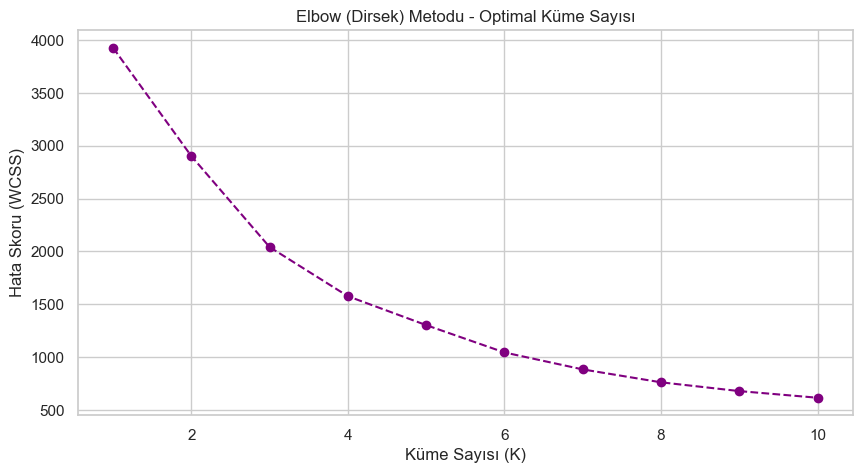

Grafiğe göre optimal küme sayısı (K) = 4 olarak belirlenmiştir.


In [4]:
# 3. OPTİMAL KÜME SAYISININ BELİRLENMESİ (ELBOW METHOD)

# Veriyi Ölçeklendirme (Scaling)
scaler = StandardScaler()
veri_seti = profil_df[['Ortalama_Tuketim', 'Standart_Sapma', 'Yazlikci_Skoru']]
veri_scaled = scaler.fit_transform(veri_seti)

# WCSS (Within-Cluster Sum of Square) hesaplama
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(veri_scaled)
    wcss.append(kmeans.inertia_)

# Grafiği Çizme
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='purple')
plt.title('Elbow (Dirsek) Metodu - Optimal Küme Sayısı')
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('Hata Skoru (WCSS)')
plt.show()

print("Grafiğe göre optimal küme sayısı (K) = 4 olarak belirlenmiştir.")

In [5]:
# 4. K-MEANS KÜMELEME (K=4)

# Modeli kurma ve eğitme
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
profil_df['Kume_No'] = kmeans_final.fit_predict(veri_scaled)

# KÜMELERİN OTOMATİK ETİKETLENMESİ
# Küme numaraları her çalıştırmada değişebilir, bu yüzden özelliklerine göre isimlendiriyoruz.

# Yazlıkçı Skoru en yüksek olan grup -> Yazlıkçı
yazlikci_kume = profil_df.groupby('Kume_No')['Yazlikci_Skoru'].mean().idxmax()

# Tüketimi en yüksek olan grup -> Anomali / Aşırı Tüketim
zengin_kume = profil_df.groupby('Kume_No')['Ortalama_Tuketim'].mean().idxmax()

# Tüketimi en düşük olan grup -> Standart / Tasarruflu
standart_kume = profil_df.groupby('Kume_No')['Ortalama_Tuketim'].mean().idxmin()

def isim_ver(kume):
    if kume == yazlikci_kume: return "Yazlıkçı / Mevsimsel"
    elif kume == zengin_kume: return "ANOMALİ (Aşırı Tüketim)"
    elif kume == standart_kume: return "Standart Sakinler"
    else: return "Yüksek Gelir / Çok Tüketen"

profil_df['Segment_Adi'] = profil_df['Kume_No'].apply(isim_ver)

print("Segmentasyon tamamlandı. Örnek sonuçlar:")
print(profil_df[['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Segment_Adi']].head())

Segmentasyon tamamlandı. Örnek sonuçlar:
     ILCE           MAHALLE  Ortalama_Tuketim           Segment_Adi
0  ALİAĞA           ATATÜRK         11.451638     Standart Sakinler
1  ALİAĞA       AŞAĞIŞAKRAN         20.913714     Standart Sakinler
2  ALİAĞA  B.HAYRETTİN PAŞA         10.887997     Standart Sakinler
3  ALİAĞA         BAHÇEDERE         19.389169  Yazlıkçı / Mevsimsel
4  ALİAĞA            BOZKÖY         19.868835  Yazlıkçı / Mevsimsel


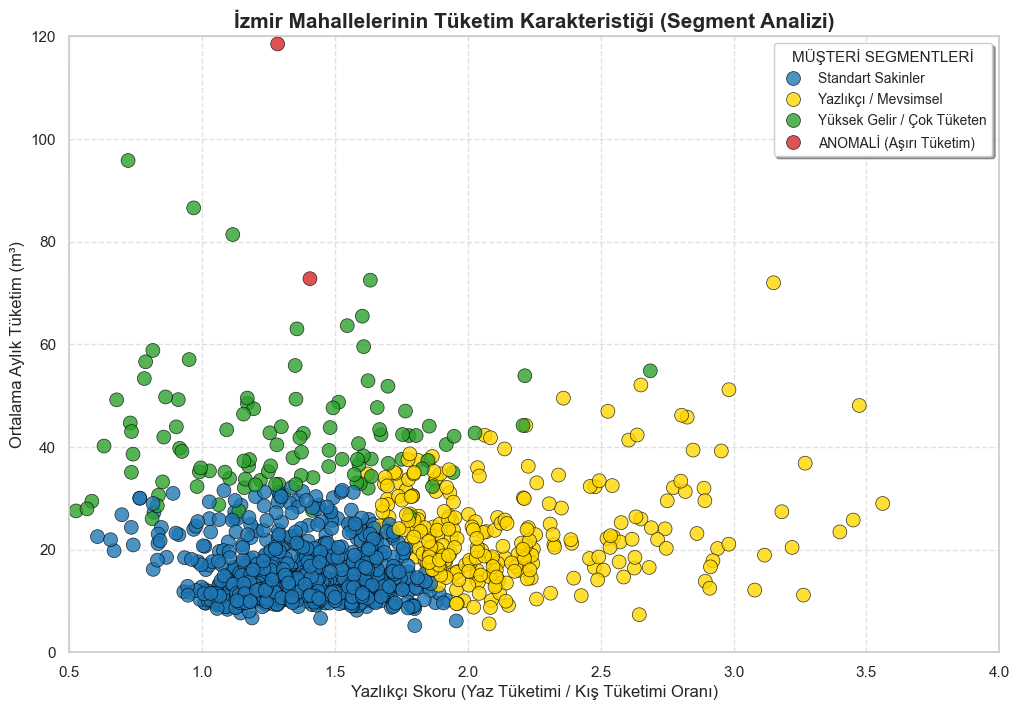

In [6]:
# 5. SONUÇLARIN GÖRSELLEŞTİRİLMESİ (ÖZEL RENK PALETİ İLE)

plt.figure(figsize=(12, 8))

# --- ÖZEL RENK TANIMLAMASI ---
# İstediğin renkleri segment isimleriyle eşleştiriyoruz.
# Standart Sakinler için 'viridis'in o tonuna yakın, göz yormayan profesyonel bir mavi seçtim.
ozel_renkler = {
    "ANOMALİ (Aşırı Tüketim)": "#d62728",       # Kırmızı (Tehlike/Alarm)
    "Standart Sakinler": "#1f77b4",             # Mavi (Sakin/Standart - Viridis'teki tona yakın)
    "Yüksek Gelir / Çok Tüketen": "#2ca02c",    # Dolar Yeşili (Gelir/Büyüme)
    "Yazlıkçı / Mevsimsel": "gold"              # Altın Sarısı (Güneş/Yaz - Beyaz zeminde sarıdan daha net görünür)
}
# -----------------------------

sns.scatterplot(
    data=profil_df,
    x='Yazlikci_Skoru',
    y='Ortalama_Tuketim',
    hue='Segment_Adi',
    palette=ozel_renkler, # <-- 'viridis' yerine kendi paletimizi kullandık
    s=100,
    alpha=0.8,
    edgecolor='black', # Noktaların etrafına ince siyah çizgi çeker, renkleri daha net ayırır.
    linewidth=0.5
)

# Görseli netleştirmek için eksen ayarları
plt.ylim(0, 120) # Y eksenini biraz daralttım ki anomaliler tavanda net görünsün
plt.xlim(0.5, 4.0)

# Başlık ve Eksen İsimleri
plt.title('İzmir Mahallelerinin Tüketim Karakteristiği (Segment Analizi)', fontsize=15, fontweight='bold')
plt.xlabel('Yazlıkçı Skoru (Yaz Tüketimi / Kış Tüketimi Oranı)', fontsize=12)
plt.ylabel('Ortalama Aylık Tüketim (m³)', fontsize=12)

# Lejant (Renk Açıklaması) Ayarı
plt.legend(title='MÜŞTERİ SEGMENTLERİ', title_fontsize='11', fontsize='10', loc='upper right', shadow=True)

# Arka plan ızgarasını hafiflet
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [7]:
# 6. RAPORLAMA VE DIŞA AKTARMA

# Türkçe Excel formatına uygun (Ayraç: Noktalı virgül, Ondalıklı Virgül)
dosya_adi = "IZMIR_RAPORU_TURKCE.csv"

profil_df.to_csv(
    dosya_adi, 
    sep=';', 
    encoding='utf-8-sig', 
    index=False, 
    decimal=','
)

print(f"✅ Analiz raporu başarıyla kaydedildi: {dosya_adi}")
print("Bu dosya Excel veya Google Sheets ile açılabilir.")

# Anomali tespiti yapılan bölgelerin listelenmesi
print("\n--- TESPİT EDİLEN KRİTİK BÖLGELER (ANOMALİ) ---")
anomaliler = profil_df[profil_df['Segment_Adi'].str.contains("ANOMALİ")]
print(anomaliler[['ILCE', 'MAHALLE', 'Ortalama_Tuketim', 'Segment_Adi']])

✅ Analiz raporu başarıyla kaydedildi: IZMIR_RAPORU_TURKCE.csv
Bu dosya Excel veya Google Sheets ile açılabilir.

--- TESPİT EDİLEN KRİTİK BÖLGELER (ANOMALİ) ---
          ILCE        MAHALLE  Ortalama_Tuketim              Segment_Adi
439   GAZİEMİR       GAZİKENT        185.572815  ANOMALİ (Aşırı Tüketim)
549  KARŞIYAKA  MUSTAFA KEMAL        118.484990  ANOMALİ (Aşırı Tüketim)
688      KONAK     HALKAPINAR         72.758784  ANOMALİ (Aşırı Tüketim)


In [8]:
# --- 7. KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
mahalle_analiz_et("GAZİKENT")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: GAZİKENT
📍 İLÇE: GAZİEMİR
💧 ORTALAMA TÜKETİM: 185.57 m³
📊 TESPİT EDİLEN SEGMENT: ANOMALİ (Aşırı Tüketim)
------------------------------
🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!
👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.
👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.



In [9]:
# --- 7. KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
mahalle_analiz_et("BOZKÖY")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: BOZKÖY
📍 İLÇE: ALİAĞA
💧 ORTALAMA TÜKETİM: 19.87 m³
📊 TESPİT EDİLEN SEGMENT: Yazlıkçı / Mevsimsel
------------------------------
☀️ [MEVSİMSEL]: Yazlık bölge davranışı.
👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.



In [10]:
# --- 7. KARAR DESTEK SİSTEMİ DEMOSU ---
# Bu blok, girilen mahallenin durumunu analiz eder ve aksiyon önerir.

def mahalle_analiz_et(mahalle_adi):
    mahalle_adi = mahalle_adi.upper() # Büyük harfe çevir
    sonuc = profil_df[profil_df['MAHALLE'].str.contains(mahalle_adi, na=False)]
    
    print("\n" + "="*60)
    print(f"🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: {mahalle_adi}")
    print("="*60)
    
    if len(sonuc) == 0:
        print("❌ HATA: Mahalle bulunamadı. Lütfen ismi kontrol edin.")
    else:
        # İlk eşleşen kaydı al
        kayit = sonuc.iloc[0]
        segment = kayit['Segment_Adi']
        tuketim = kayit['Ortalama_Tuketim']
        
        print(f"📍 İLÇE: {kayit['ILCE']}")
        print(f"💧 ORTALAMA TÜKETİM: {tuketim:.2f} m³")
        print(f"📊 TESPİT EDİLEN SEGMENT: {segment}")
        print("-" * 30)
        
        # Yapay Zeka Aksiyon Önerileri
        if "ANOMALİ" in segment:
            print("🚨 [KRİTİK UYARI]: AŞIRI TÜKETİM TESPİT EDİLDİ!")
            print("👉 EYLEM PLANI: Kaçak tespit ekibi derhal yönlendirilmeli.")
            print("👉 TAHMİN: Şebeke patlağı veya ticari usulsüzlük ihtimali %90.")
        elif "Yazlıkçı" in segment:
            print("☀️ [MEVSİMSEL]: Yazlık bölge davranışı.")
            print("👉 EYLEM PLANI: Yaz aylarında şebeke basıncı artırılmalı.")
        else:
            print("✅ [NORMAL]: Standart tüketim davranışı.")
            print("👉 EYLEM PLANI: Rutin kontroller devam etsin.")
            
    print("="*60 + "\n")

# --- DEMO ÇALIŞTIRMA ---
mahalle_analiz_et("ALSANCAK")


🤖 İZMİR SU YÖNETİM SİSTEMİ - ANALİZ RAPORU: ALSANCAK
📍 İLÇE: KONAK
💧 ORTALAMA TÜKETİM: 11.90 m³
📊 TESPİT EDİLEN SEGMENT: Standart Sakinler
------------------------------
✅ [NORMAL]: Standart tüketim davranışı.
👉 EYLEM PLANI: Rutin kontroller devam etsin.



 TAHMİN MODÜLÜ ÇALIŞTIRILIYOR...
MODEL ADI                      R2 SKORU   MAPE (%)  
-------------------------------------------------------
Random Forest                  0.8470     %2.89
AdaBoost                       0.8248     %3.34
Gradient Boosting (Yeni)       0.6545     %3.98
KNN Regresyon                  0.6730     %4.48
Decision Tree                  0.6354     %5.10
SVR (Destek Vektör)            -0.6267     %8.74

--- AKADEMİK KARŞILAŞTIRMA TABLOSU ---
                      Model  R2_Score      MAPE
0             Random Forest  0.847005  2.893038
1                 AdaBoost   0.824775  3.343411
3             KNN Regresyon  0.672960  4.477231
2  Gradient Boosting (Yeni)  0.654450  3.975402
4             Decision Tree  0.635351  5.095789
5       SVR (Destek Vektör) -0.626730  8.744113


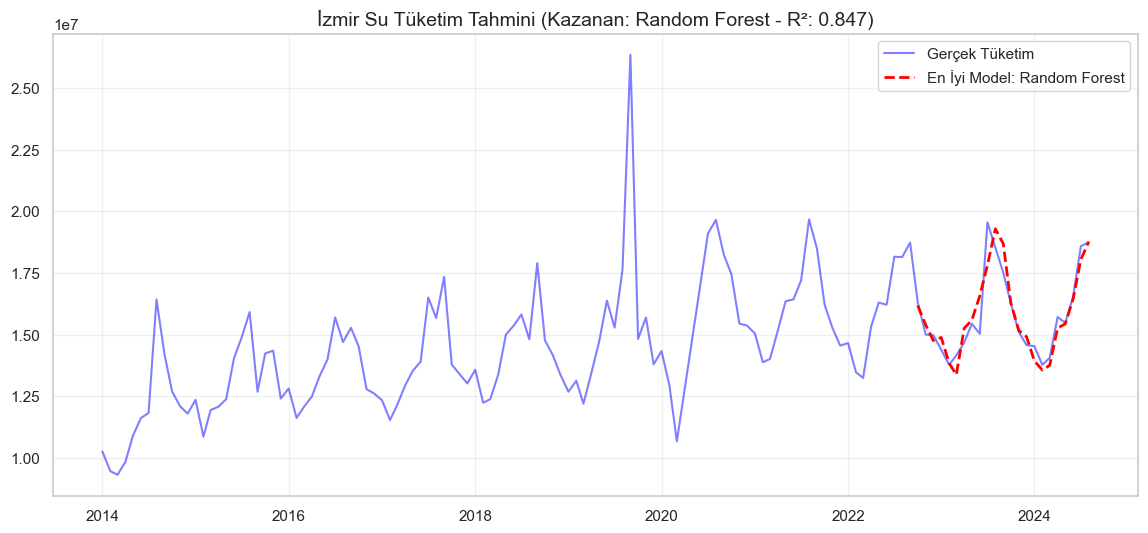

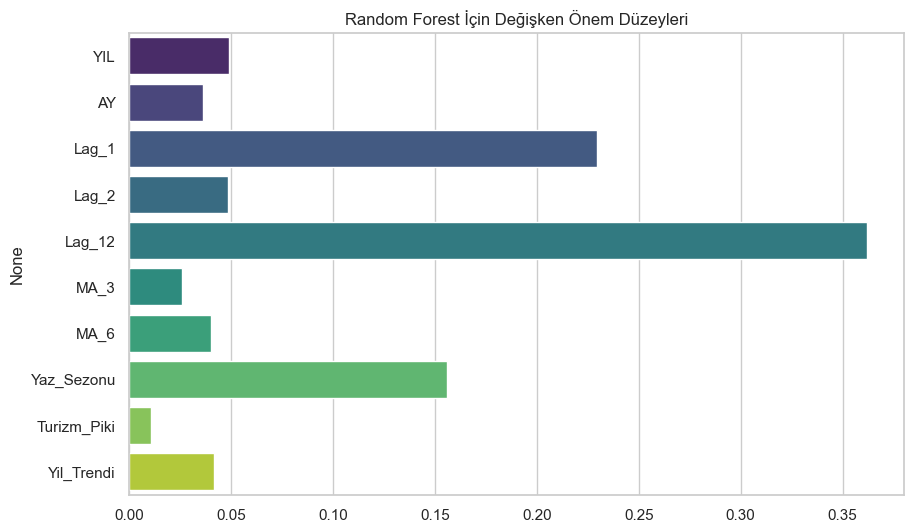

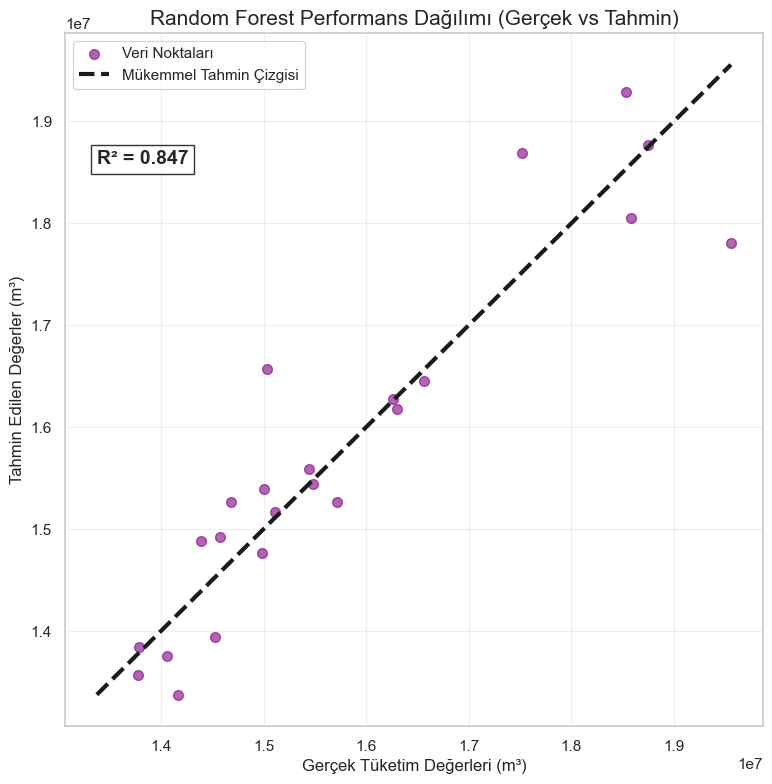

In [11]:
# --- 8. MODEL KARŞILAŞTIRMA VE TAHMİN ---

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(" TAHMİN MODÜLÜ ÇALIŞTIRILIYOR...")

# 1. VERİ HAZIRLIĞI (Zaman Serisi)
zaman_serisi = df_final.groupby(['YIL', 'AY'])['TOPLAM_TUKETIM'].sum().reset_index()
zaman_serisi['Tarih'] = pd.to_datetime(zaman_serisi['YIL'].astype(str) + '-' + zaman_serisi['AY'].astype(str) + '-01')
zaman_serisi = zaman_serisi.sort_values('Tarih')

# Veri Temizliği
ortalama = zaman_serisi['TOPLAM_TUKETIM'].mean()
alt_limit = ortalama * 0.50 
ust_limit = ortalama * 2.0
zaman_serisi = zaman_serisi[(zaman_serisi['TOPLAM_TUKETIM'] > alt_limit) & 
                            (zaman_serisi['TOPLAM_TUKETIM'] < ust_limit)].copy()

# 2. GELİŞMİŞ ÖZNİTELİK MÜHENDİSLİĞİ 
# DÜZELTME: Veri sızıntısını önlemek için .shift() kullanıldı.
# Böylece model, tahmin edeceği ayın verisini asla görmüyor.

# A. Geçmiş Veriler (Lags) - 
zaman_serisi['Lag_1'] = zaman_serisi['TOPLAM_TUKETIM'].shift(1)  # Geçen ay
zaman_serisi['Lag_2'] = zaman_serisi['TOPLAM_TUKETIM'].shift(2)  # 2 ay önce
zaman_serisi['Lag_12'] = zaman_serisi['TOPLAM_TUKETIM'].shift(12) # Geçen yıl aynı ay

# B. Hareketli Ortalamalar (Trend) - 

# Son 3 ayın ortalaması (O anki ay HARİÇ)
zaman_serisi['MA_3'] = zaman_serisi['TOPLAM_TUKETIM'].shift(1).rolling(window=3).mean()

# Son 6 ayın ortalaması (O anki ay HARİÇ)
zaman_serisi['MA_6'] = zaman_serisi['TOPLAM_TUKETIM'].shift(1).rolling(window=6).mean()

# C. Mevsimsel Kukla Değişkenler
zaman_serisi['Yaz_Sezonu'] = zaman_serisi['AY'].apply(lambda x: 1 if x in [6, 7, 8, 9] else 0)
zaman_serisi['Turizm_Piki'] = zaman_serisi['AY'].apply(lambda x: 1 if x in [7, 8] else 0)
zaman_serisi['Yil_Trendi'] = zaman_serisi['YIL'] - zaman_serisi['YIL'].min()

# NaN temizliği 
veri_model = zaman_serisi.dropna()

# 3. MODEL EĞİTİMİ (MODEL YARIŞTIRMA)
X = veri_model[['YIL', 'AY', 'Lag_1', 'Lag_2', 'Lag_12', 'MA_3', 'MA_6', 'Yaz_Sezonu', 'Turizm_Piki', 'Yil_Trendi']]
y = veri_model['TOPLAM_TUKETIM']

# Zaman serisi olduğu için shuffle=False yapıyoruz (Geçmişle geleceği eğitiyoruz)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Yarıştırılacak Modeller
modeller = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "AdaBoost ": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (Yeni)": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN Regresyon": KNeighborsRegressor(n_neighbors=5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR (Destek Vektör)": SVR(kernel='rbf')
}

sonuclar = []

print(f"{'MODEL ADI':<30} {'R2 SKORU':<10} {'MAPE (%)':<10}")
print("-" * 55)

en_iyi_skor = -999
en_iyi_model_adi = ""
en_iyi_tahminler = []

for isim, model in modeller.items():
    model.fit(X_train, y_train)
    tahmin = model.predict(X_test)
    
    r2 = r2_score(y_test, tahmin)
    mape = mean_absolute_percentage_error(y_test, tahmin) * 100
    
    sonuclar.append({"Model": isim, "R2_Score": r2, "MAPE": mape})
    print(f"{isim:<30} {r2:.4f}     %{mape:.2f}")
    
    if r2 > en_iyi_skor:
        en_iyi_skor = r2
        en_iyi_model_adi = isim
        en_iyi_tahminler = tahmin
        en_iyi_model_obj = model # Feature importance için 

# 4. SONUÇLARIN TABLO HALİNE GETİRİLMESİ
sonuc_df = pd.DataFrame(sonuclar).sort_values(by="R2_Score", ascending=False)
print("\n--- AKADEMİK KARŞILAŞTIRMA TABLOSU ---")
print(sonuc_df)

# 5. EN İYİ MODELİN GRAFİĞİ
plt.figure(figsize=(14, 6))
plt.plot(zaman_serisi['Tarih'], zaman_serisi['TOPLAM_TUKETIM'], label='Gerçek Tüketim', color='blue', alpha=0.5)
test_tarihleri = zaman_serisi.loc[y_test.index, 'Tarih']
plt.plot(test_tarihleri, en_iyi_tahminler, label=f'En İyi Model: {en_iyi_model_adi}', color='red', linestyle='--', linewidth=2)
plt.title(f'İzmir Su Tüketim Tahmini (Kazanan: {en_iyi_model_adi} - R²: {en_iyi_skor:.3f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. FEATURE IMPORTANCE (Sadece Ağaç tabanlı modellerde çalışır)
if "Forest" in en_iyi_model_adi or "Boost" in en_iyi_model_adi or "Tree" in en_iyi_model_adi:
    onem_dereceleri = en_iyi_model_obj.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=onem_dereceleri, y=X.columns, hue=X.columns, legend=False, palette='viridis')
    plt.title(f'{en_iyi_model_adi} İçin Değişken Önem Düzeyleri')
    plt.show() 
    
# --- 7. GERÇEK VS TAHMİN DAĞILIM GRAFİĞİ (SCATTER PLOT) ---

plt.figure(figsize=(9, 9))

# Noktaları çiz (Gerçek vs Tahmin)
plt.scatter(y_test, en_iyi_tahminler, alpha=0.6, color='purple', s=50, label='Veri Noktaları')

# Mükemmel Tahmin Çizgisi (x=y doğrusu)
# Eğer model hatasız olsaydı tüm noktalar bu siyah çizgi üzerinde olurdu.
min_val = min(y_test.min(), en_iyi_tahminler.min())
max_val = max(y_test.max(), en_iyi_tahminler.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=3, label='Mükemmel Tahmin Çizgisi')

plt.title(f'{en_iyi_model_adi} Performans Dağılımı (Gerçek vs Tahmin)', fontsize=15)
plt.xlabel('Gerçek Tüketim Değerleri (m³)', fontsize=12)
plt.ylabel('Tahmin Edilen Değerler (m³)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# R2 Skorunu grafiğin üzerine yazalım (Haval ı durur)
plt.text(min_val, max_val*0.95, f'R² = {en_iyi_skor:.3f}', fontsize=14, fontweight='bold', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()